# Adding imports

In [1]:
import requests
import os
import json
import datetime
import logging as logger
import cv2
import numpy as np
import face_recognition

from os.path import join, dirname
from dotenv import load_dotenv
from bs4 import BeautifulSoup
from moviepy.editor import *
from keras.models import model_from_json

2023-12-03 18:16:51.755065: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-03 18:16:51.756723: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-03 18:16:51.781297: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-03 18:16:51.781332: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-03 18:16:51.782056: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## Loading environment and local variables

In [ ]:
dotenv_path = join(dirname(os.path.abspath('')), '.env')
load_dotenv(dotenv_path)
os.chdir('/app')

logger.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')

def dump_json(data, path):
    with open(path, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)


def get_twitch_token():
    payload = {
        'client_id' : os.environ.get("CLIENT_ID"),
        'client_secret': os.environ.get("CLIENT_SECRET"),
        'grant_type': 'client_credentials'
    }
    headers = {'Content-Type': 'application/x-www-form-urlencoded'}
    response = requests.post("https://id.twitch.tv/oauth2/token", headers=headers, data=payload)

    return json.loads(response.text)["access_token"]


token = get_twitch_token()
headers = {'Authorization': f'Bearer {token}', 'Client-Id': os.environ.get("CLIENT_ID")}

In [4]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


In [ ]:
def get_streamers():
    '''
    Retreive from a third party website the list of the most watched streamers
    Returns a list of strings
    '''
    results = []
    request = requests.get('https://www.twitchmetrics.net/channels/viewership?game=League+of+Legends&lang=en&page=1')
    parsed_html = BeautifulSoup(request.text)

    for name in parsed_html.body.find_all('h5', attrs={'class':'mr-2 mb-0'}):
        results.append(name.get_text())
    
    return results



In [ ]:
def convert_name_to_id(name):
    '''
        Converts the basic name (e.g. Thebausffs) to the broadcaster id, which twitch uses to identify the streamer
        There are some exceptions with names, that involve whitespaces between them: only staff members can use them, and when putting
        the name in the endpoint will result in a error, so the name has to be stripped of it
    '''
    params = { "login" : "".join(name.split()) }
    request = requests.get(f'https://api.twitch.tv/helix/users', headers=headers, params=params)
    if request.ok:
        return json.loads(request.text)["data"][0]["id"]
    else:
        raise Exception(f'Error from twitch endpoint {request.text}')



In [ ]:
def clips_from_broadcaster_id(id):
    '''Retreives the clips from a streamer, based also on timeframe, and sorted by views'''
    format_time = "%Y-%m-%dT%H:%M:%SZ"
    params = {
        "broadcaster_id" : id,
        "started_at" : (datetime.datetime.now() - datetime.timedelta(days=3)).strftime(format_time),
        "ended_at" : datetime.datetime.now().strftime(format_time)
    }
    request = requests.get(f'https://api.twitch.tv/helix/clips', headers=headers, params=params)
    return json.loads(request.text)["data"]



In [ ]:
def download_clip(clip):
    path = join(dirname(os.path.abspath('')), f'files/clips/{clip["title"]}.mp4')
    index = clip["thumbnail_url"].find('-preview')
    clip_url = clip["thumbnail_url"][:index] + '.mp4'
    r = requests.get(clip_url)

    if r.headers['Content-Type'] == 'binary/octet-stream':
        if not os.path.exists('files/clips'): os.makedirs('files/clips')
        with open(path, 'wb') as f:
            f.write(r.content)
        return path
    else:
        print(f'Failed to download clip from thumb: {clip["thumbnail_url"]}')



In [ ]:
def overlay_video(original_video, overlay_video):
    output_path="output.mp4"

    video_clip = VideoFileClip((original_video), target_resolution=(1080, 1920)) #b .mp4 file

    overlay_clip = VideoFileClip((overlay_video), has_mask=True, target_resolution=(1080, 1920)) #.mov file with alpha channel

    final_video = CompositeVideoClip([video_clip, overlay_clip])  


    final_video.write_videofile(
        output_path,
        threads = 6,
    )

In [ ]:
def main():
    logger.info('Program started')
    logger.info('BRUH')

    time = 2 * 60
    video_time = 0

    clips = []

    streamers = get_streamers()

    for streamer in streamers:
        if streamer == "Riot Games":
            continue
        streamer_id = convert_name_to_id(streamer)
        clips_downloaded = clips_from_broadcaster_id(streamer_id)[:3]
        if video_time > time:
            break
        for clip in clips_downloaded:
            video_time += float(clip["duration"])
            clips.append(download_clip(clip))
    
    transition_time = 2
    video_clips = [VideoFileClip(clips.pop(0))]
    
    for clip in clips:
        video_clips.append(VideoFileClip(clip).crossfadein(transition_time))

    final = concatenate_videoclips(video_clips, padding=-transition_time, method="compose")
    final.write_videofile("files/clips/final_output.mp4")
    #Adding intro
    overlay_video("files/clips/final_output.mp4", "files/intro.mov")


In [ ]:
main()

# Original

In [2]:
def read_video_emotion(video):

    vidcap = cv2.VideoCapture(f'/app/files/clips/{video}')
    success,image = vidcap.read()
    
    if not success:
        print("Video not correctly loaded, presumably not there")
    
    results_percentage = {'angry': 0, 'disgust': 0, 'fear': 0, 'happy': 0, 'neutral': 0, 'sad': 0, 'surprise': 0}
    labels = {0 : 'angry', 1 : 'disgust', 2 : 'fear', 3 : 'happy', 4 : 'neutral', 5 : 'sad', 6 : 'surprise'}

    
    
    def extract_features(face_image):
        smaller_face_image = cv2.resize(face_image,(48,48))
        feature = np.array(smaller_face_image)
        feature = feature.reshape(1,48,48,1)
        return feature/255.0
    
    json_file = open("/app/files/models/emotion/emotiondetector.json", "r")
    model = model_from_json(json_file.read())
    json_file.close()
    model.load_weights("/app/files/models/emotion/emotiondetector.h5")

    multp = 3
    skip = 0
    
    while success:
        success,image = vidcap.read()

        if success is False:
            break

        #Elaborate 1 in each X frames for efficency. Faces don't change that quicly
        if skip < 90:
            skip += 1
            continue

        skip = 0
        
        #Reduce the size of the image to examine for efficency purposes
        face_locations = face_recognition.face_locations(cv2.resize(image, (0, 0), fx=1/multp, fy=1/multp), model="cnn")
        
        if len(face_locations) == 0:
            continue
        
        gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        top, right, bottom, left = face_locations[0]
        face_image = gray[top*multp : bottom*multp, left*multp : right*multp]
        
        
        extracted_img = extract_features(face_image)
        with HiddenPrints():
            pred = model.predict(extracted_img)
        results_percentage[labels[pred.argmax()]] += 1

    return results_percentage

In [ ]:
bruh = read_video_emotion("ner.mp4")

In [28]:
%%time
results = read_video_emotion('b.mp4')

CPU times: user 1min 18s, sys: 9.31 s, total: 1min 27s
Wall time: 1min 21s


In [29]:
results

{'angry': 3,
 'disgust': 1,
 'fear': 1,
 'happy': 7,
 'neutral': 3,
 'sad': 0,
 'surprise': 1}

In [26]:
print("brt")
video = 'b.mp4'


results_percentage = {'angry': 0, 'disgust': 0, 'fear': 0, 'happy': 0, 'neutral': 0, 'sad': 0, 'surprise': 0}
labels = {0 : 'angry', 1 : 'disgust', 2 : 'fear', 3 : 'happy', 4 : 'neutral', 5 : 'sad', 6 : 'surprise'}



def extract_features(face_image):
    smaller_face_image = cv2.resize(face_image,(48,48))
    feature = np.array(smaller_face_image)
    feature = feature.reshape(1,48,48,1)
    return feature/255.0

json_file = open("/app/files/models/emotion/emotiondetector.json", "r")
model = model_from_json(json_file.read())
json_file.close()
model.load_weights("/app/files/models/emotion/emotiondetector.h5")

vidcap = cv2.VideoCapture('/app/files/clips/b.mp4')
success,image = vidcap.read()

multp = 3
skip = 0
frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
print("??????")
while success:
    frames-=1
    success,image = vidcap.read()
    if success is False:
        break

    print(frames)
    
    #Elaborate 1 in each X frames for efficency. Faces don't change that quicly
    if skip < 100:
        skip += 1
        continue

    skip = 0
    #Reduce the size of the image to examine for efficency purposes
    face_locations = face_recognition.face_locations(cv2.resize(image, (0, 0), fx=1/multp, fy=1/multp), model="cnn")
    
    if len(face_locations) == 0:
        continue

    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    top, right, bottom, left = face_locations[0]
    face_image = gray[top*multp : bottom*multp, left*multp : right*multp]
    
    extracted_img = extract_features(face_image)
    with HiddenPrints():
        pred = model.predict(extracted_img)
    results_percentage[labels[pred.argmax()]] += 1

brt
??????
1799
1798
1797
1796
1795
1794
1793
1792
1791
1790
1789
1788
1787
1786
1785
1784
1783
1782
1781
1780
1779
1778
1777
1776
1775
1774
1773
1772
1771
1770
1769
1768
1767
1766
1765
1764
1763
1762
1761
1760
1759
1758
1757
1756
1755
1754
1753
1752
1751
1750
1749
1748
1747
1746
1745
1744
1743
1742
1741
1740
1739
1738
1737
1736
1735
1734
1733
1732
1731
1730
1729
1728
1727
1726
1725
1724
1723
1722
1721
1720
1719
1718
1717
1716
1715
1714
1713
1712
1711
1710
1709
1708
1707
1706
1705
1704
1703
1702
1701
1700
1699
1698
1697
1696
1695
1694
1693
1692
1691
1690
1689
1688
1687
1686
1685
1684
1683
1682
1681
1680
1679
1678
1677
1676
1675
1674
1673
1672
1671
1670
1669
1668
1667
1666
1665
1664
1663
1662
1661
1660
1659
1658
1657
1656
1655
1654
1653
1652
1651
1650
1649
1648
1647
1646
1645
1644
1643
1642
1641
1640
1639
1638
1637
1636
1635
1634
1633
1632
1631
1630
1629
1628
1627
1626
1625
1624
1623
1622
1621
1620
1619
1618
1617
1616
1615
1614
1613
1612
1611
1610
1609
1608
1607
1606
1605
1604
1603
1602

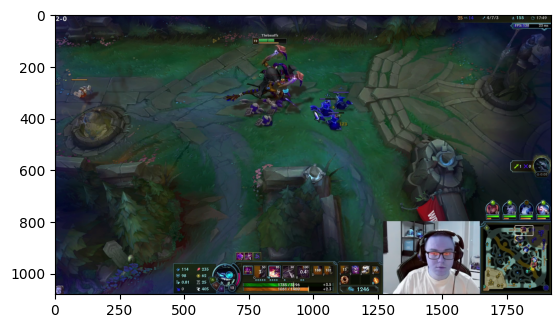

Read a new frame:  True


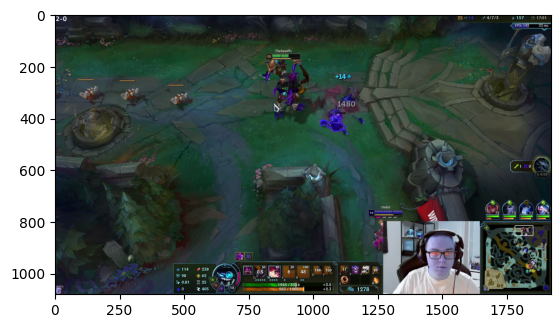

Read a new frame:  True


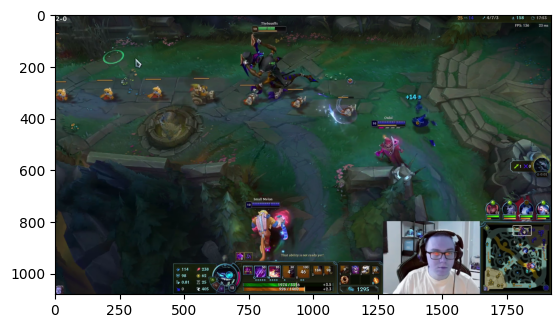

Read a new frame:  True


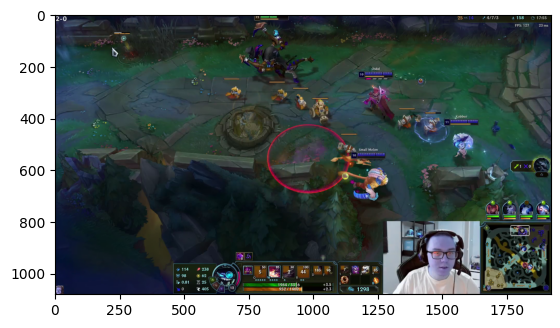

Read a new frame:  True


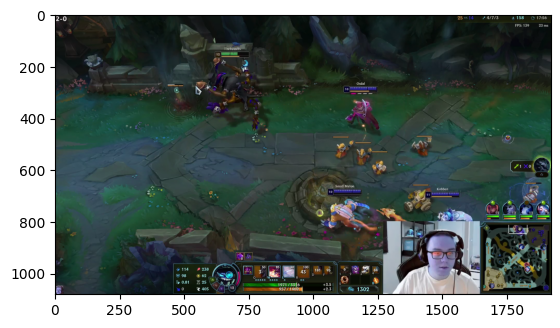

Read a new frame:  True


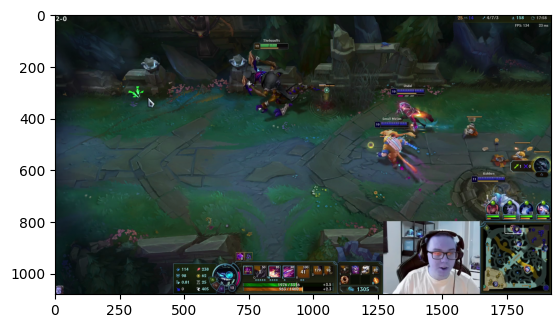

Read a new frame:  True


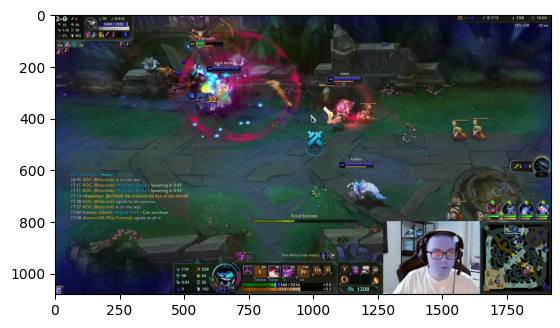

Read a new frame:  True


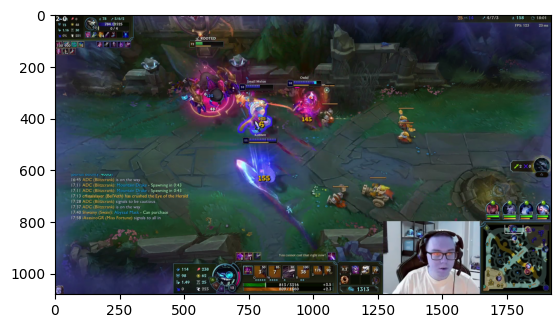

Read a new frame:  True


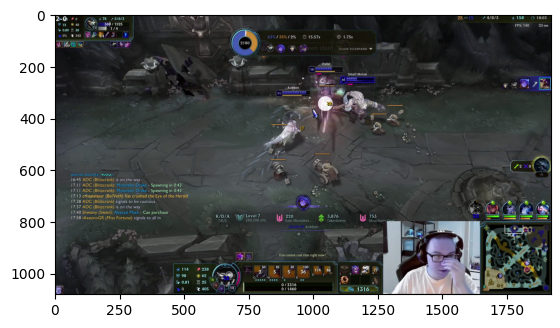

Read a new frame:  True


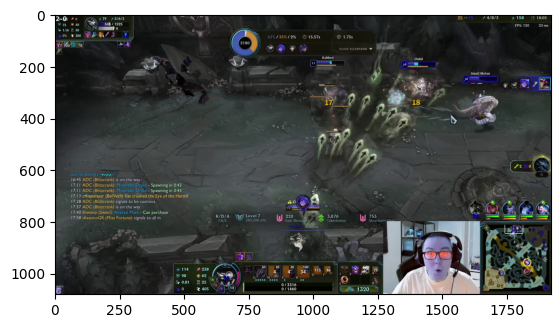

Read a new frame:  True


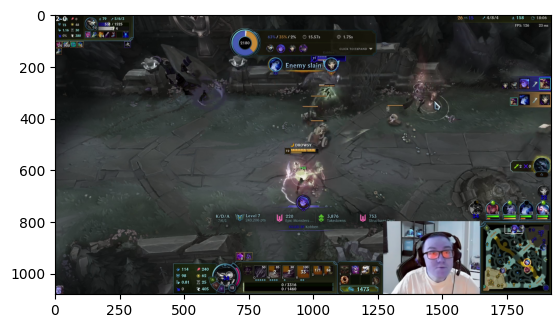

Read a new frame:  True


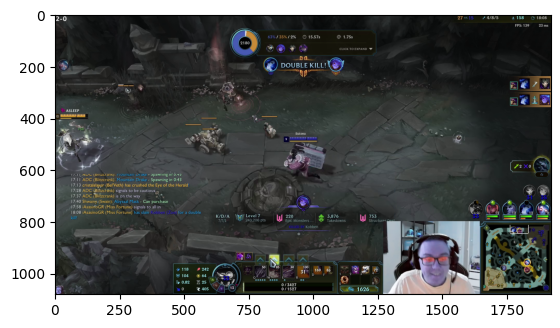

Read a new frame:  True


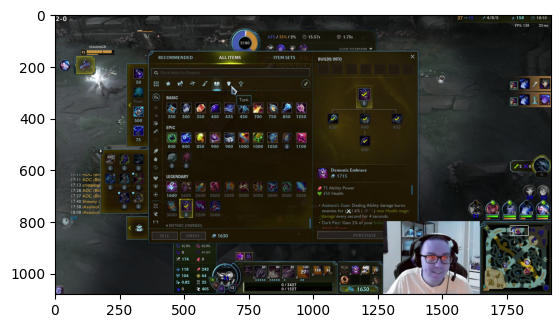

Read a new frame:  True


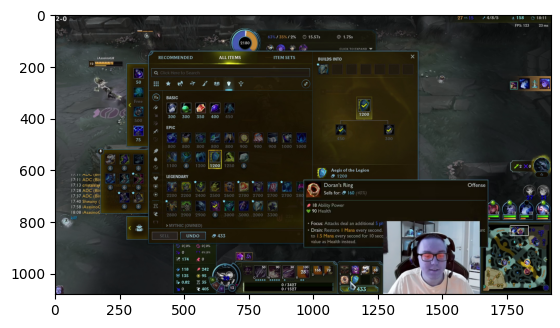

Read a new frame:  True


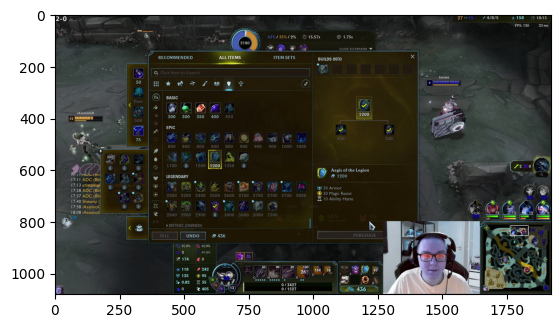

Read a new frame:  True


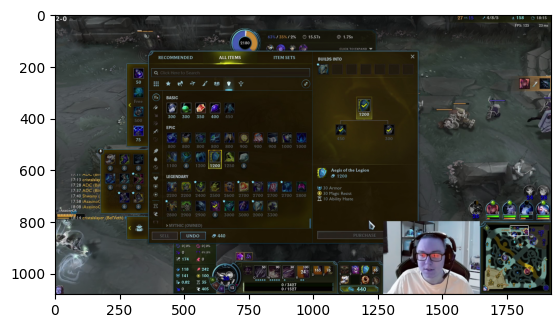

Read a new frame:  True



KeyboardInterrupt



In [17]:
import cv2
vidcap = cv2.VideoCapture('/app/files/clips/b.mp4')
success,image = vidcap.read()
count = 100
counter = 0
while success:
    success,image = vidcap.read()
    if counter < count:
        counter+= 1
        continue
    counter = 0
    import matplotlib.pyplot as plt
    imgplot = plt.imshow(image)
    plt.show()   # save frame as JPEG file      
    
    print('Read a new frame: ', success)


# Testing Face-Recognition

In [ ]:
face_locations = face_recognition.face_locations(cv2.resize(image, (0, 0), fx=1/multiplier, fy=1/multiplier), model="cnn")
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
for (top, right, bottom, left) in face_locations[0]:
    print("Face found")
    top *= multiplier
    right *= multiplier
    bottom *= multiplier
    left *= multiplier


    face_image = gray[top:bottom, left:right]
    smaller_face_image = cv2.resize(face_image,(48,48))
    img = extract_features(smaller_face_image)
    pred = model.predict(img)
    prediction_label = labels[pred.argmax()]
    results_percentage[prediction_label] += 1

In [ ]:
top, right, bottom, left = face_locations[0]

In [ ]:
results_percentage

# Getting the same array as before

In [ ]:
extracted_features = None

In [ ]:
video = 'nein.mp4'
results_percentage = {'angry': 0, 'disgust': 0, 'fear': 0, 'happy': 0, 'neutral': 0, 'sad': 0, 'surprise': 0}
count = 0

def extract_features(image):
    feature = np.array(image)
    feature = feature.reshape(1,48,48,1)
    return feature/255.0

json_file = open("/app/files/models/emotion/emotiondetector.json", "r")
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)

model.load_weights("/app/files/models/emotion/emotiondetector.h5")
haar_file=cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
face_cascade=cv2.CascadeClassifier(haar_file)

labels = {0 : 'angry', 1 : 'disgust', 2 : 'fear', 3 : 'happy', 4 : 'neutral', 5 : 'sad', 6 : 'surprise'}

vidcap = cv2.VideoCapture(join(dirname(os.path.abspath('')),f'files/clips/{video}'))
success,image = vidcap.read()
faces = face_cascade.detectMultiScale(image,1.3,5)
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
print(faces)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

for (p,q,r,s) in faces:
    count += 1
    image = gray[q:q + s, p:p + r]
    image = cv2.resize(image,(48,48))
    img = extract_features(image)
    extracted_features = img
    pred = model.predict(img)
    prediction_label = labels[pred.argmax()]
    results_percentage[prediction_label] += 1
    print(prediction_label)
    break

In [ ]:
extracted_features

In [ ]:
bruh.shape

In [ ]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()